In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

In [2]:
# B --> Batch Size
# C --> Number of Input Channels
# IH --> Image Height
# IW --> Image Width
# P --> Patch Size
# E --> Embedding Dimension
# N --> Number of Patches = IH/P * IW/P
# S --> Sequence Length   = IH/P * IW/P + 1 or N + 1 (extra 1 is of Classification Token)
# Q --> Query Sequence length (equal to S for self-attention)
# K --> Key Sequence length   (equal to S for self-attention)
# V --> Value Sequence length (equal to S for self-attention)
# H --> Number of heads
# HE --> Head Embedding Dimension = E/H
# CL --> Number of Classes

class EmbedLayer(nn.Module):
    """
    Class for Embedding an Image.
    It breaks image into patches and embeds patches using a Conv2D Operation (Works same as the Linear layer).
    Next, a learnable positional embedding vector is added to all the patch embeddings to provide spatial position.
    Finally, a classification token is added which is used to classify the image.

    Parameters:
        n_channels (int) : Number of channels of the input image
        embed_dim  (int) : Embedding dimension
        image_size (int) : Image size
        patch_size (int) : Patch size
        dropout  (float) : dropout value

    Input:
        x (tensor): Image Tensor of shape B, C, IW, IH

    Returns:
        Tensor: Embedding of the image of shape B, S, E
    """
    def __init__(self, n_channels, embed_dim, image_size, patch_size, dropout=0.0):
        super().__init__()
        self.conv1         = nn.Conv2d(n_channels, embed_dim, kernel_size=patch_size, stride=patch_size)                       # Patch Encoding
        self.pos_embedding = nn.Parameter(torch.zeros(1, (image_size // patch_size) ** 2, embed_dim), requires_grad=True)      # Learnable Positional Embedding
        self.cls_token     = nn.Parameter(torch.zeros(1, 1, embed_dim), requires_grad=True)                                    # Classification Token
        self.dropout       = nn.Dropout(dropout)

    def forward(self, x):
        B = x.shape[0]
        x = self.conv1(x)                                                         # B, C, IH, IW     --> B, E, IH/P, IW/P                Split image into the patches and embed patches
        x = x.reshape([B, x.shape[1], -1])                                        # B, E, IH/P, IW/P --> B, E, (IH/P*IW/P) --> B, E, N    Flattening the patches
        x = x.permute(0, 2, 1)                                                    # B, E, N          --> B, N, E                         Rearrange to put sequence dimension in the middle
        x = x + self.pos_embedding                                                # B, N, E          --> B, N, E                         Add positional embedding
        x = torch.cat((torch.repeat_interleave(self.cls_token, B, 0), x), dim=1)  # B, N, E          --> B, (N+1), E       --> B, S, E    Add classification token at the start of every sequence
        x = self.dropout(x)
        return x


class SelfAttention(nn.Module):
    """
    Class for computing self attention Self-Attention

    Parameters:
        embed_dim (int)        : Embedding dimension
        n_attention_heads (int): Number of attention heads to use for performing MultiHeadAttention

    Input:
        x (tensor): Tensor of shape B, S, E

    Returns:
        Tensor: Output after Self-Attention Module of shape B, S, E
    """
    def __init__(self, embed_dim, n_attention_heads):
        super().__init__()
        self.embed_dim          = embed_dim
        self.n_attention_heads  = n_attention_heads
        self.head_embed_dim     = embed_dim // n_attention_heads

        self.queries            = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)   # Queries projection
        self.keys               = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)   # Keys projection
        self.values             = nn.Linear(self.embed_dim, self.head_embed_dim * self.n_attention_heads)   # Values projection
        self.out_projection     = nn.Linear(self.head_embed_dim * self.n_attention_heads, self.embed_dim)   # Out projection

    def forward(self, x):
        b, s, e = x.shape  # Note: In case of self-attention Q, K and V are all equal to S

        xq = self.queries(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)     # B, Q, E      -->  B, Q, (H*HE)  -->  B, Q, H, HE
        xq = xq.permute(0, 2, 1, 3)                                                         # B, Q, H, HE  -->  B, H, Q, HE
        xk = self.keys(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)        # B, K, E      -->  B, K, (H*HE)  -->  B, K, H, HE
        xk = xk.permute(0, 2, 1, 3)                                                         # B, K, H, HE  -->  B, H, K, HE
        xv = self.values(x).reshape(b, s, self.n_attention_heads, self.head_embed_dim)      # B, V, E      -->  B, V, (H*HE)  -->  B, V, H, HE
        xv = xv.permute(0, 2, 1, 3)                                                         # B, V, H, HE  -->  B, H, V, HE


        # Compute Attention presoftmax values
        xk = xk.permute(0, 1, 3, 2)                                                         # B, H, K, HE  -->  B, H, HE, K
        x_attention = torch.matmul(xq, xk)                                                  # B, H, Q, HE  *   B, H, HE, K   -->  B, H, Q, K    (Matmul tutorial eg: A, B, C, D  *  A, B, E, F  -->  A, B, C, F   if D==E)

        x_attention /= float(self.head_embed_dim) ** 0.5                                    # Scale presoftmax values for stability

        x_attention = torch.softmax(x_attention, dim=-1)                                    # Compute Attention Matrix

        x = torch.matmul(x_attention, xv)                                                   # B, H, Q, K  *  B, H, V, HE  -->  B, H, Q, HE     Compute Attention product with Values

        # Format the output
        x = x.permute(0, 2, 1, 3)                                                           # B, H, Q, HE --> B, Q, H, HE
        x = x.reshape(b, s, e)                                                              # B, Q, H, HE --> B, Q, (H*HE)

        x = self.out_projection(x)                                                          # B, Q,(H*HE) --> B, Q, E
        return x


class Encoder(nn.Module):
    """
    Class for creating an encoder layer

    Parameters:
        embed_dim (int)         : Embedding dimension
        n_attention_heads (int) : Number of attention heads to use for performing MultiHeadAttention
        forward_mul (float)     : Used to calculate dimension of the hidden fc layer = embed_dim * forward_mul
        dropout (float)         : Dropout parameter

    Input:
        x (tensor): Tensor of shape B, S, E

    Returns:
        Tensor: Output of the encoder block of shape B, S, E
    """
    def __init__(self, embed_dim, n_attention_heads, forward_mul, dropout=0.0):
        super().__init__()
        self.norm1      = nn.LayerNorm(embed_dim)
        self.attention  = SelfAttention(embed_dim, n_attention_heads)
        self.dropout1   = nn.Dropout(dropout)

        self.norm2      = nn.LayerNorm(embed_dim)
        self.fc1        = nn.Linear(embed_dim, embed_dim * forward_mul)
        self.activation = nn.GELU()
        self.fc2        = nn.Linear(embed_dim * forward_mul, embed_dim)
        self.dropout2   = nn.Dropout(dropout)

    def forward(self, x):
        x = x + self.dropout1(self.attention(self.norm1(x)))                                # Skip connections
        x = x + self.dropout2(self.fc2(self.activation(self.fc1(self.norm2(x)))))           # Skip connections
        return x


class Classifier(nn.Module):
    """
    Classification module of the Vision Transformer. Uses the embedding of the classification token to generate logits.

    Parameters:
        embed_dim (int) : Embedding dimension
        n_classes (int) : Number of classes

    Input:
        x (tensor): Tensor of shape B, S, E

    Returns:
        Tensor: Logits of shape B, CL
    """

    def __init__(self, embed_dim, n_classes):
        super().__init__()
        # New architectures skip fc1 and activations and directly apply fc2.
        self.fc1        = nn.Linear(embed_dim, embed_dim)
        self.activation = nn.Tanh()
        self.fc2        = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        x = x[:, 0, :]              # B, S, E --> B, E          Get CLS token
        x = self.fc1(x)             # B, E    --> B, E
        x = self.activation(x)      # B, E    --> B, E
        x = self.fc2(x)             # B, E    --> B, CL
        return x


class VisionTransformer(nn.Module):
    """
    Vision Transformer Class.

    Parameters:
        n_channels (int)        : Number of channels of the input image
        embed_dim  (int)        : Embedding dimension
        n_layers   (int)        : Number of encoder blocks to use
        n_attention_heads (int) : Number of attention heads to use for performing MultiHeadAttention
        forward_mul (float)     : Used to calculate dimension of the hidden fc layer = embed_dim * forward_mul
        image_size (int)        : Image size
        patch_size (int)        : Patch size
        n_classes (int)         : Number of classes
        dropout  (float)        : dropout value

    Input:
        x (tensor): Image Tensor of shape B, C, IW, IH

    Returns:
        Tensor: Logits of shape B, CL
    """
    def __init__(self, n_channels, embed_dim, n_layers, n_attention_heads, forward_mul, image_size, patch_size, n_classes, dropout=0.1):
        super().__init__()
        self.embedding  = EmbedLayer(n_channels, embed_dim, image_size, patch_size, dropout=dropout)
        self.encoder    = nn.ModuleList([Encoder(embed_dim, n_attention_heads, forward_mul, dropout=dropout) for _ in range(n_layers)])
        self.norm       = nn.LayerNorm(embed_dim)                                       # Final normalization layer after the last block
        self.classifier = Classifier(embed_dim, n_classes)

        self.apply(vit_init_weights)                                                    # Weight initalization

    def forward(self, x):
        x = self.embedding(x)
        for block in self.encoder:
            x = block(x)
        x = self.norm(x)
        x = self.classifier(x)
        return x


def vit_init_weights(m):
    """
    function for initializing the weights of the Vision Transformer.
    """

    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.trunc_normal_(m.weight, mean=0.0, std=0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

    elif isinstance(m, nn.LayerNorm):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

    elif isinstance(m, EmbedLayer):
        nn.init.trunc_normal_(m.cls_token, mean=0.0, std=0.02)
        nn.init.trunc_normal_(m.pos_embedding, mean=0.0, std=0.02)

In [3]:
# Prepare the Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))  # Correct mean and std for FashionMNIST
])

train_dataset = torchvision.datasets.FashionMNIST(root='./cnn-data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./cnn-data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

100%|██████████| 26.4M/26.4M [00:02<00:00, 10.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 168kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.13MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 15.8MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [14]:
# Initialize the Model, Loss Function, and Optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VisionTransformer(
    n_channels=1,
    embed_dim=128,
    n_layers=6,
    n_attention_heads=8,
    forward_mul=4,
    image_size=28,
    patch_size=7,
    n_classes=10,
    dropout=0.1
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)



In [15]:
# Lists to store metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
all_labels = []
all_predictions = []

# Training Loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Compute training accuracy and loss
    train_accuracy = 100 * correct_train / total_train
    train_loss = running_loss / len(train_loader)
    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Collect predictions and labels for ROC curve
            probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
            all_labels.append(labels.cpu().numpy())
            all_predictions.append(probabilities)

    # Compute test accuracy and loss
    test_accuracy = 100 * correct_test / total_test
    test_loss /= len(test_loader)
    test_accuracies.append(test_accuracy)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


Epoch [1/10], Training Loss: 1.1599, Training Accuracy: 65.65%, Test Loss: 0.6869, Test Accuracy: 77.56%
Epoch [2/10], Training Loss: 0.5700, Training Accuracy: 80.77%, Test Loss: 0.5046, Test Accuracy: 82.53%
Epoch [3/10], Training Loss: 0.4676, Training Accuracy: 83.77%, Test Loss: 0.4661, Test Accuracy: 83.64%
Epoch [4/10], Training Loss: 0.4234, Training Accuracy: 85.16%, Test Loss: 0.4349, Test Accuracy: 84.54%
Epoch [5/10], Training Loss: 0.3957, Training Accuracy: 85.99%, Test Loss: 0.3964, Test Accuracy: 85.54%
Epoch [6/10], Training Loss: 0.3763, Training Accuracy: 86.56%, Test Loss: 0.3973, Test Accuracy: 85.95%
Epoch [7/10], Training Loss: 0.3610, Training Accuracy: 87.05%, Test Loss: 0.3825, Test Accuracy: 86.31%
Epoch [8/10], Training Loss: 0.3454, Training Accuracy: 87.53%, Test Loss: 0.3846, Test Accuracy: 86.08%
Epoch [9/10], Training Loss: 0.3345, Training Accuracy: 87.91%, Test Loss: 0.3652, Test Accuracy: 86.56%
Epoch [10/10], Training Loss: 0.3253, Training Accuracy

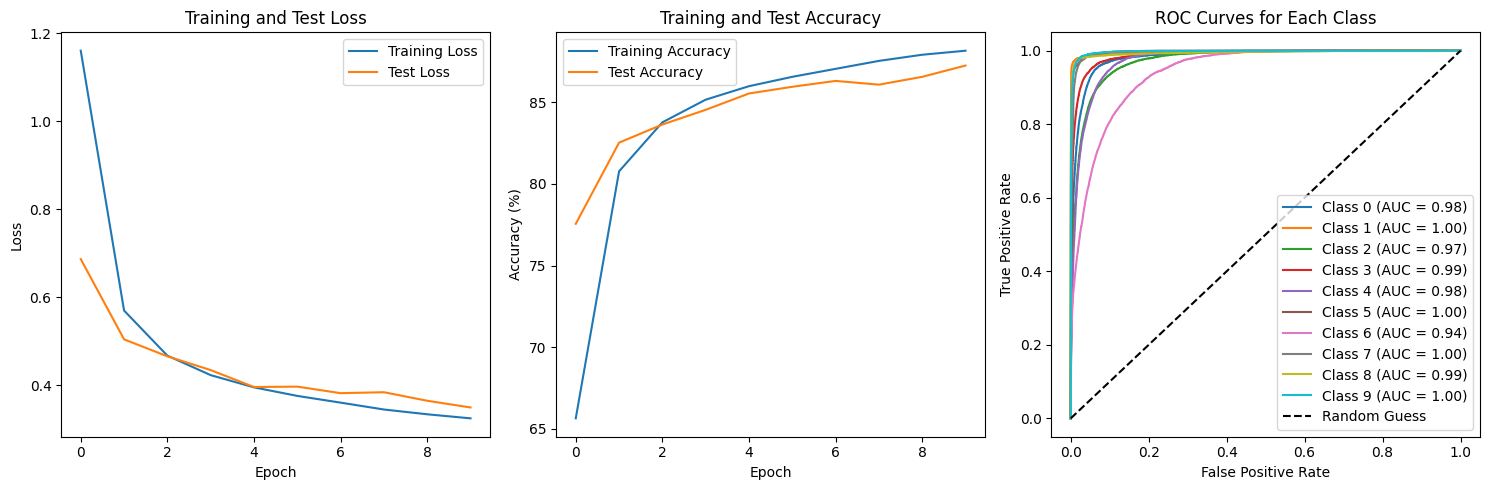

In [16]:
# Convert predictions and labels to numpy arrays
all_labels = np.concatenate(all_labels, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):  # 10 classes in FashionMNIST
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), all_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot Training and Test Loss Curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()

# Plot Training and Test Accuracy Curves
plt.subplot(1, 3, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()

# Plot ROC Curves
plt.subplot(1, 3, 3)
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend()

plt.tight_layout()
plt.show()